In [1]:
import torch
import numpy as np
from dist_ae import SetAutoencoderGNN, SetAutoencoderTx, SetAutoencoderHybrid, train_w_stop
from losses import sliced_wasserstein_distance, mmd, sinkhorn
from distns import distns
from tqdm.notebook import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

distn_name = 'poisson'
generate_params = distns[distn_name]['generate_params']
sample_distn = distns[distn_name]['sample']
fr_dist = distns[distn_name]['fr_dist']

In [2]:
d = {'Set size': [], 'N sets': [], 'Architecture': [], 'Loss': [], 'Param. MSE': []}

set_sizes = np.logspace(0, 3, 3, dtype=int)
n_sets = np.logspace(2, 3, 3, dtype=int)
n_features = 2

loss_fns = {
    'SWD': lambda X, Y: torch.vmap(sliced_wasserstein_distance, randomness='different')(X, Y).mean(),
    # 'MMD': lambda X, Y: torch.vmap(mmd, randomness='different')(X, Y).mean(),
    # 'Sinkhorn' : lambda X, Y: torch.vmap(sinkhorn, randomness='different')(X, Y).mean(),
}

architectures = {
    'DistAE-GNN': SetAutoencoderGNN,
    'DistAE-Attn': SetAutoencoderTx,
    'DistAE-Hybrid' : SetAutoencoderHybrid
}

for set_size in tqdm(set_sizes, desc='set sizes'):
    for set_number in tqdm(n_sets, desc='set_number', leave=False):
        params_train = generate_params(set_number, n_features)
        params_val = generate_params(set_number // 2, n_features)
        params_test = generate_params(1000, n_features)

        x_train = sample_distn(*params_train, set_number, set_size, n_features)
        x_val = sample_distn(*params_val, set_number // 2, set_size, n_features)
        x_test = sample_distn(*params_test, 1000, set_size, n_features)

        train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(torch.from_numpy(x_val).float(), batch_size=32, shuffle=False)

        for name, ae_class in architectures.items():
            for loss_name, loss_fn in loss_fns.items():
                model = ae_class(n_features, 16, 64, set_size)
                optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
                model = train_w_stop(model, optimizer, train_loader, val_loader, loss_fn, 
                                     max_epochs=100, device='cuda', verbose=False, patience=100)
                with torch.no_grad():
                    _, rec = model(torch.from_numpy(x_test).float().cuda())
                mse = ((rec.mean(axis=1).cpu() - params_test[0])**2).mean().item()
                
                d['Set size'].append(set_size)
                d['N sets'].append(set_number)
                d['Architecture'].append(name)
                d['Loss'].append(loss_name)
                d['Param. MSE'].append(mse)

set sizes:   0%|          | 0/3 [00:00<?, ?it/s]

set_number:   0%|          | 0/3 [00:00<?, ?it/s]

set_number:   0%|          | 0/3 [00:00<?, ?it/s]

set_number:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
res_df = pd.DataFrame(d)
res_df

,Set size,N sets,Architecture,Loss,Param. MSE
0,1,100,DistAE-GNN,SWD,462.314824
1,1,100,DistAE-Attn,SWD,1464.881434
2,1,100,DistAE-Hybrid,SWD,1445.582917
3,1,316,DistAE-GNN,SWD,456.742239
4,1,316,DistAE-Attn,SWD,196.202816
5,1,316,DistAE-Hybrid,SWD,256.412906
6,1,1000,DistAE-GNN,SWD,454.692071
7,1,1000,DistAE-Attn,SWD,48.355040
8,1,1000,DistAE-Hybrid,SWD,48.993636
9,31,100,DistAE-GNN,SWD,415.303043


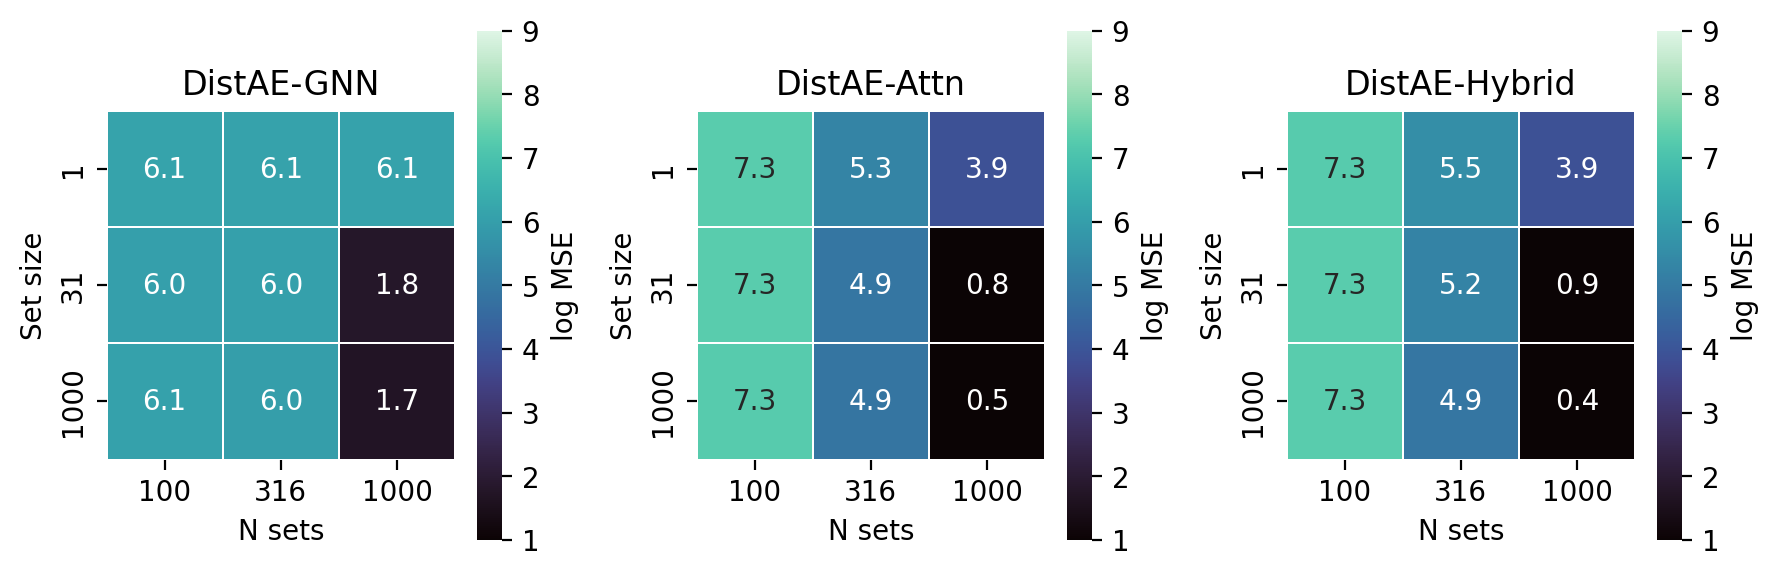

In [4]:
res_df['log_MSE'] = np.log(res_df['Param. MSE'])
archs = res_df['Architecture'].unique()

fig, axes = plt.subplots(1, len(archs), figsize=(9, 3), dpi=200)
for ax, arch in zip(axes, archs):
    pivot = res_df[res_df['Architecture'] == arch].pivot_table(index='Set size', 
                                                               columns='N sets', 
                                                               values='log_MSE')
    sns.heatmap(pivot, ax=ax, cmap='mako', annot=True, fmt='.1f',
                square=True, cbar_kws={'label': 'log MSE'}, lw=0.1,
                vmin=1, vmax=9,)
    ax.set_title(arch)

plt.tight_layout()
plt.show()

In [5]:
res_df.to_csv('numerical_results/convergence_2D_pois.csv')